In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import pickle

import timecast as tc
import pandas as pd
import matplotlib.pyplot as plt

import flax
import jax.numpy as jnp
import numpy as np

from timecast.learners import AR
from timecast.utils.ar import historify, compute_gram

In [222]:
data = jnp.array(pd.read_csv("../data/wind/original/MS_winds.dat", names=list(range(57))))
pickle.dump(data, open("../data/wind/original/MS_winds.pkl", "wb"))

In [223]:
# Columns = 57 stations
# Rows = wind speed readings (m/s)
data

DeviceArray([[5.0963, 2.0564, 3.0399, ..., 3.0399, 3.5763, 2.5481],
             [5.0963, 1.5199, 2.5481, ..., 2.5481, 3.5763, 2.5481],
             [5.588 , 1.5199, 2.0564, ..., 2.5481, 3.5763, 1.5199],
             ...,
             [4.6045, 4.0681, 5.0963, ..., 4.6045, 0.    , 3.0399],
             [7.1526, 6.1244, 4.6045, ..., 4.0681, 0.    , 4.0681],
             [7.1526, 3.5763, 3.0399, ..., 4.0681, 0.    , 4.6045]],            dtype=float32)

In [224]:
# Normalization
# NOTE: This is a bug; they claim this normalizes from 0 to 1, but it doesn't
# NOTE: Their variable also refer to min and max as mean and std, respectively so...
data_min = data.min()
data_max = data.max()
data = (data - data_min) / data_max

In [181]:
models = pickle.load(open("../data/wind/original/models.pkl", "rb"))["models"]
models_mse = pickle.load(open("../skgaip/wind/models_mse.pkl", "rb"))["models"]

In [7]:
# Mostly from https://github.com/amirstar/Deep-Forecast/blob/4dcdf66f8ae3070ab706b30a6e3cf888f36e0536/multiLSTM.py#L210
def predict(X, models):
    X = X.reshape(X.shape[0], history_len, num_stations)
    results = np.zeros_like(np.zeros((X.shape[0], num_stations)))
    
    for ind in range(len(X)):
        modelInd = ind % 6
        if modelInd == 0:
            testInputRaw = X[ind]
            testInputShape = testInputRaw.shape
            testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
        else:
            testInputRaw = np.vstack((testInputRaw, results[ind-1]))
            testInput = np.delete(testInputRaw, 0, axis=0)
            testInputShape = testInput.shape
            testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])
    
        pred = models[modelInd].predict(testInput)
        results[ind] = pred

    return jnp.array(results)

In [268]:
num_train = 6000
num_test = 361

history_len = 12
num_stations = 57

In [100]:
# 12..5999
train_true = data[history_len:num_train]
# 0..11, 1..12, ..., 5987..5998
train_data = historify(data, history_len=history_len, num_histories=train_true.shape[0])

# 6012..8386
test_true = data[num_train + history_len:]
# 6000..6011, ..., 8374..8385
test_data = historify(data, history_len=history_len, num_histories=test_true.shape[0], offset=num_train)

In [101]:
# 6012..8386
test_pred = predict(test_data, models)

In [182]:
test_pred_mse = predict(test_data, models_mse)

In [189]:
test_resid = test_true - test_pred
test_resid_mse = test_true - test_pred_mse

In [134]:
# Metric: mean absolute error
jnp.absolute((test_true - test_pred) * data_max + data_min).mean(axis=0).mean()

DeviceArray(1.3113904, dtype=float32)

In [183]:
jnp.absolute((test_true - test_pred_mse) * data_max + data_min).mean(axis=0).mean()

DeviceArray(1.4005028, dtype=float32)

In [135]:
# Metric: mean squared error
# Metric: mean absolute error
jnp.square((test_true - test_pred) * data_max + data_min).mean(axis=0).mean()

DeviceArray(3.181298, dtype=float32)

In [184]:
jnp.square((test_true - test_pred_mse) * data_max + data_min).mean(axis=0).mean()

DeviceArray(3.705796, dtype=float32)

In [13]:
# 12..5999
train_pred = predict(train_data, models)

In [146]:
ars, states = [None] * num_stations, [None] * num_stations
padded_test_resid = jnp.vstack((jnp.zeros((history_len - 1, num_stations)), test_resid))
for station in tqdm.tqdm(range(num_stations)):
    ars[station], states[station] = AR.fit(
        data=[(data[num_train:-1], padded_test_resid[:, station], None)],
        input_dim=num_stations,
        output_dim=1,
        history=data[num_train : num_train + history_len],
        history_len=history_len,
        alpha=0.1
    )

In [193]:
# https://stackoverflow.com/questions/51883058/l1-norm-instead-of-l2-norm-for-cost-function-in-regression-model

from scipy.optimize import minimize

def fit(X, params):
    return X @ params

def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))

L1_ars = [None] * num_stations
for station in tqdm.tqdm(range(num_stations)):
    init_params = ars[station].params["Linear"]["kernel"].reshape(history_len * num_stations, 1)
    init_params = np.vstack((np.zeros((1, 1)), init_params))
    L1_ars[station] = minimize(cost_function, init_params, args=(np.hstack((np.ones((test_data.shape[0], 1)), test_data)), test_resid[:, station]))

In [194]:
# https://stackoverflow.com/questions/51883058/l1-norm-instead-of-l2-norm-for-cost-function-in-regression-model

from scipy.optimize import minimize

def fit(X, params):
    return X @ params

def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))

L1_ars_mse = [None] * num_stations
for station in tqdm.tqdm(range(num_stations)):
    init_params = ars[station].params["Linear"]["kernel"].reshape(history_len * num_stations, 1)
    init_params = np.vstack((np.zeros((1, 1)), init_params))
    L1_ars_mse[station] = minimize(cost_function, init_params, args=(np.hstack((np.ones((test_data.shape[0], 1)), test_data)), test_resid_mse[:, station]))

In [195]:
from sklearn.linear_model import Ridge

In [196]:
L2_ars = [None] * num_stations
for station in tqdm.tqdm(range(num_stations)):
    L2_ars[station] = Ridge(alpha=0.1)
    L2_ars[station].fit(test_data, test_resid[:, station])
    

In [197]:
L2_ars_mse = [None] * num_stations
for station in tqdm.tqdm(range(num_stations)):
    L2_ars_mse[station] = Ridge(alpha=0.1)
    L2_ars_mse[station].fit(test_data, test_resid_mse[:, station])

In [198]:
maes = []
for station in tqdm.tqdm(range(num_stations)):
    y_hat = test_pred[:, station] + np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ L1_ars[station].x
    maes.append(np.absolute((test_true[:, station] - y_hat) * data_max + data_min).mean())

In [199]:
maes_mse = []
for station in tqdm.tqdm(range(num_stations)):
    y_hat = test_pred_mse[:, station] + np.hstack((np.ones((test_data.shape[0], 1)), test_data)) @ L1_ars_mse[station].x
    maes_mse.append(np.absolute((test_true[:, station] - y_hat) * data_max + data_min).mean())

In [200]:
np.mean(maes)

0.9944389

In [204]:
np.mean(maes_mse)

1.1200277

In [201]:
mses = []
for station in tqdm.tqdm(range(num_stations)):
    y_hat = test_pred[:, station] + test_data @ L2_ars[station].coef_ + L2_ars[station].intercept_
    mses.append(np.square((test_true[:, station] - y_hat) * data_max + data_min).mean())

In [202]:
mses_mse = []
for station in tqdm.tqdm(range(num_stations)):
    y_hat = test_pred_mse[:, station] + test_data @ L2_ars_mse[station].coef_ + L2_ars_mse[station].intercept_
    mses_mse.append(np.square((test_true[:, station] - y_hat) * data_max + data_min).mean())

In [203]:
np.mean(mses)

1.2649621

In [205]:
np.mean(mses_mse)

1.5544692

In [244]:
import jax.numpy as jnp
import pickle

from timecast.learners import Sequential, Parallel, BlackBox, AR
from timecast import tmap
from timecast.objectives import residual
from timecast.optim import GradientDescent

maes_online = []
for station in tqdm.tqdm(range(num_stations)):
    lr = -5
    num_train = 6000

    lstm = BlackBox.partial(arr=test_pred[:, station])
    ar = AR.partial(
        output_dim=1,
        history=data[num_train : num_train + history_len - 1],
        history_len=history_len
    )
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ar])
    model.params["AR_1"]["Linear"]["kernel"] = L1_ars[station].x[1:].reshape(1, history_len * num_stations, 1)
    model.params["AR_1"]["Linear"]["bias"] = L1_ars[station].x[[0]]

    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)

    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]

    Y_hat, optimizer, state = tmap(X, Y, optimizer, state=state, objective=residual)

    mae = jnp.absolute((Y - Y_hat) * data_max + data_min).mean()
    maes_online.append(mae)

In [248]:
import jax.numpy as jnp
import pickle

from timecast.learners import Sequential, Parallel, BlackBox, AR
from timecast import tmap
from timecast.objectives import residual
from timecast.optim import GradientDescent

mses_online = []
for station in tqdm.tqdm(range(num_stations)):
    lr = -5
    num_train = 6000

    lstm = BlackBox.partial(arr=test_pred[:, station])
    ar = AR.partial(
        output_dim=1,
        history=data[num_train : num_train + history_len - 1],
        history_len=history_len
    )
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ar])
    model.params["AR_1"]["Linear"]["kernel"] = L2_ars[station].coef_.reshape(1, history_len * num_stations, 1)
    model.params["AR_1"]["Linear"]["bias"] = L2_ars[station].intercept_.reshape(1)

    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)

    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]

    Y_hat, optimizer, state = tmap(X, Y, optimizer, state=state, objective=residual)

    mse = jnp.square((Y - Y_hat) * data_max + data_min).mean()
    mses_online.append(mse)

In [269]:
import jax.numpy as jnp
import pickle

from timecast.learners import Sequential, Parallel, BlackBox, AR
from timecast import tmap
from timecast.objectives import residual
from timecast.optim import GradientDescent

maes_mse_online = []
for station in tqdm.tqdm(range(num_stations)):
    lr = -5
    num_train = 6000

    lstm = BlackBox.partial(arr=test_pred_mse[:, station])
    ar = AR.partial(
        output_dim=1,
        history=data[num_train : num_train + history_len - 1],
        history_len=history_len
    )
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ar])
    model.params["AR_1"]["Linear"]["kernel"] = L1_ars_mse[station].x[1:].reshape(1, history_len * num_stations, 1)
    model.params["AR_1"]["Linear"]["bias"] = L1_ars_mse[station].x[[0]]

    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)

    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]

    Y_hat, optimizer, state = tmap(X, Y, optimizer, state=state, objective=residual)

    mae_mse = jnp.absolute((Y - Y_hat) * data_max + data_min).mean()
    maes_mse_online.append(mae_mse)

In [270]:
import jax.numpy as jnp
import pickle

from timecast.learners import Sequential, Parallel, BlackBox, AR
from timecast import tmap
from timecast.objectives import residual
from timecast.optim import GradientDescent

mses_mse_online = []
for station in tqdm.tqdm(range(num_stations)):
    lr = -5
    num_train = 6000

    lstm = BlackBox.partial(arr=test_pred_mse[:, station])
    ar = AR.partial(
        output_dim=1,
        history=data[num_train : num_train + history_len - 1],
        history_len=history_len
    )
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ar])
    model.params["AR_1"]["Linear"]["kernel"] = L2_ars_mse[station].coef_.reshape(1, history_len * num_stations, 1)
    model.params["AR_1"]["Linear"]["bias"] = L2_ars_mse[station].intercept_.reshape(1)

    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)

    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]

    Y_hat, optimizer, state = tmap(X, Y, optimizer, state=state, objective=residual)

    mse_mse = jnp.square((Y - Y_hat) * data_max + data_min).mean()
    mses_mse_online.append(mse_mse)

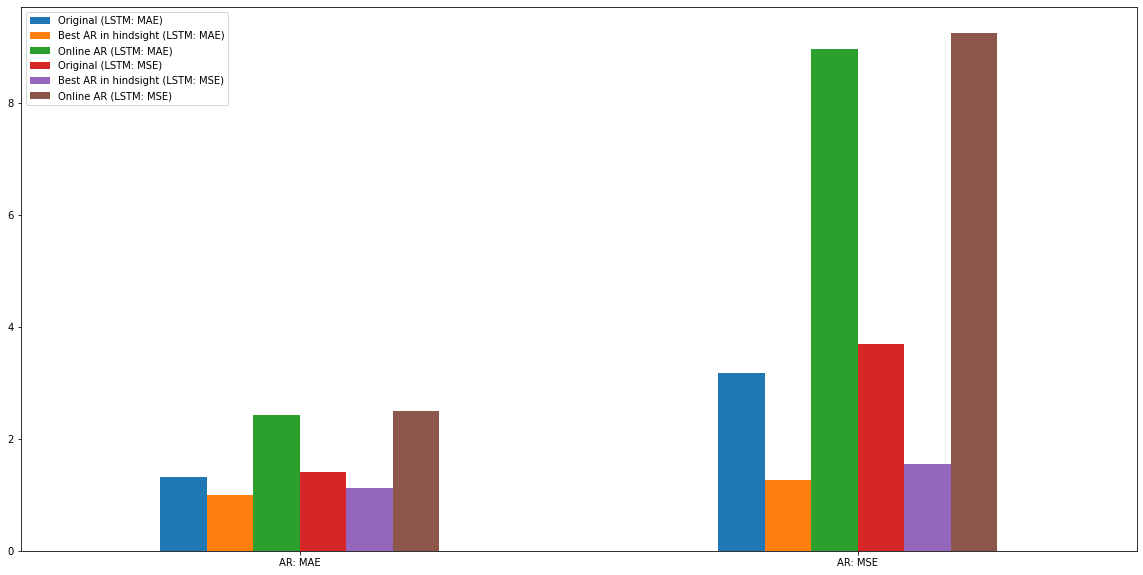

In [271]:
results = {
    "Original (LSTM: MAE)": {},
    "Best AR in hindsight (LSTM: MAE)": {},
    "Online AR (LSTM: MAE)": {},
    "Original (LSTM: MSE)": {},
    "Best AR in hindsight (LSTM: MSE)": {},
    "Online AR (LSTM: MSE)": {}
}

results["Original (LSTM: MAE)"]["AR: MAE"] = np.absolute((test_true - test_pred) * data_max + data_min).mean(axis=0).mean()
results["Original (LSTM: MAE)"]["AR: MSE"] = np.square((test_true - test_pred) * data_max + data_min).mean(axis=0).mean()
results["Best AR in hindsight (LSTM: MAE)"]["AR: MAE"] = np.mean(maes)
results["Best AR in hindsight (LSTM: MAE)"]["AR: MSE"] = np.mean(mses)
results["Online AR (LSTM: MAE)"]["AR: MAE"] = np.mean(maes_online)
results["Online AR (LSTM: MAE)"]["AR: MSE"] = np.mean(mses_online)

results["Original (LSTM: MSE)"]["AR: MAE"] = np.absolute((test_true - test_pred_mse) * data_max + data_min).mean(axis=0).mean()
results["Original (LSTM: MSE)"]["AR: MSE"] = np.square((test_true - test_pred_mse) * data_max + data_min).mean(axis=0).mean()
results["Best AR in hindsight (LSTM: MSE)"]["AR: MAE"] = np.mean(maes_mse)
results["Best AR in hindsight (LSTM: MSE)"]["AR: MSE"] = np.mean(mses_mse)
results["Online AR (LSTM: MSE)"]["AR: MAE"] = np.mean(maes_mse_online)
results["Online AR (LSTM: MSE)"]["AR: MSE"] = np.mean(mses_mse_online)

df = pd.DataFrame.from_dict(results)

df.plot(kind="bar", rot=0)

In [272]:
for station in tqdm.tqdm(range(num_stations)):
    params = {
        "kernel": L2_ars_mse[station].coef_.reshape(1, history_len * num_stations, 1),
        "bias": L2_ars_mse[station].intercept_.reshape(1)
    }
    pickle.dump(params, open("../data/wind/ar/mse/{}.pkl".format(station), "wb"))

In [277]:
for station in tqdm.tqdm(range(num_stations)):
    base = test_pred_mse[:, station]
    pickle.dump(base, open("../data/wind/base/mse/{}.pkl".format(station), "wb"))

In [278]:
@tc.experiment("station", range(num_stations))
@tc.experiment("lr", jnp.linspace(-7, -4, 13))
@tc.experiment("history_len", [4, 8, 12, 16])
def runner(station, history_len, lr=-5):
    import jax.numpy as jnp
    import pickle
    
    from timecast.learners import Sequential, Parallel, BlackBox, AR
    from timecast import tscan
    from timecast.objectives import residual
    from timecast.optim import GradientDescent
    
    num_train = 6000
    num_stations = 57

    data = jnp.asarray(pickle.load(open("../data/wind/original/MS_winds.pkl", "rb")))
    data_min = data.min()
    data_max = data.max()
    data = (data - data_min) / data_max
    
    Y_lstm = jnp.asarray(pickle.load(open("../data/wind/base/mse/{}.pkl".format(station), "rb")))
    params = pickle.load(open("../data/wind/ar/mse/{}.pkl".format(station), "rb"))
    
    lstm = BlackBox.partial(arr=Y_lstm)
    ar = AR.partial(
        output_dim=1,
        history=data[num_train : num_train + history_len - 1],
        history_len=history_len
    )
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ar])
    model.params["AR"] = params

    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)

    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]

    Y_hat, optimizer, state = tscan(X, Y, optimizer, state=state, objective=residual)
    
    return {
        "station": station,
        "lr": lr,
        "history_len": history_len,
        "mae": jnp.square((Y - Y_hat) * data_max + data_min).mean()
    }

In [279]:
results = runner.run(processes=15, tqdm=tqdm)

In [280]:
df = {}
for lr in jnp.linspace(-7, -4, 13):
    df[lr] = {}
    for history_len in [4, 8, 12, 16]:
        df[lr][history_len] = np.mean([result["mae"] for result in results if (result["lr"] == lr and result["history_len"] == history_len)])

In [281]:
df = pd.DataFrame.from_records(df)

In [282]:
df

,-7.00,-6.75,-6.50,-6.25,-6.00,-5.75,-5.50,-5.25,-5.00,-4.75,-4.50,-4.25,-4.00
4,7.213592,7.213050,7.212097,7.210431,7.207555,7.202707,7.194880,7.183209,7.168308,7.154948,7.153719,7.174310,7.212046
8,7.218698,7.217873,7.216430,7.213943,7.209761,7.203033,7.193079,7.180573,7.169864,7.170317,7.190647,7.228813,7.280174
12,7.224702,7.223701,7.221961,7.218999,7.214134,7.206635,7.196404,7.185639,7.180882,7.191673,7.222910,7.273510,7.351175
16,7.230819,7.229600,7.227499,7.223960,7.218263,7.209808,7.199102,7.189677,7.189427,7.207074,7.245674,7.307358,7.404505
